In [2]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
current_year = datetime.now().year

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nehab\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
df = pd.read_csv('final_cleaned.csv', index_col = False)
car_data_encoded = pd.get_dummies(df, columns=['Model Full Name', 'Drivetrain', 'Vehicle Class'], drop_first=True)
selected_topics = ['Topic_0', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_7', 'Topic_8', 'Topic_9']
#selected_topics = ['Topic_0','Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_7', 'Topic_8', 'Topic_9']
for topic in selected_topics:
    car_data_encoded[f'{topic}_Weighted'] = car_data_encoded[topic] * car_data_encoded['Sentiment Score']

weighted_topic_features = [f'{topic}_Weighted' for topic in selected_topics]
alpha_values = [0.1, 1.0, 10.0, 20, 50, 75, 100,200,400,500,700,1000]

In [69]:
df[[col for col in df.columns if col.startswith('Drive')]].value_counts()

Drivetrain
FWD           6010
AWD           3158
2WD           2336
RWD           1998
4WD           1758
Name: count, dtype: int64

In [51]:
functional_features = [
    'Horsepower (hp)', 'Curb Weight (lbs)', 'Combined MPG', 'Fuel Capacity (gallons)', 'Age'
] + [col for col in car_data_encoded.columns if col.startswith('Drivetrain_')]

vehicle_class_features = [col for col in car_data_encoded.columns if col.startswith('Vehicle Class_')]

functional_features += vehicle_class_features

features = functional_features
features = (functional_features + weighted_topic_features + [col for col in car_data_encoded.columns if col.startswith('Car Brand_')] 
    + [col for col in car_data_encoded.columns if col.startswith('Car Model_')])

aggregated_data = df.groupby(['Model Full Name', 'Year']).agg({
    'Horsepower (hp)': 'mean',
    'Curb Weight (lbs)': 'mean',
    'Combined MPG': 'mean',
    'Fuel Capacity (gallons)': 'mean',
    'Age': 'mean',
    'Average KBB Fair Price ($)': 'mean',
    'Vehicle Class': 'first',
    'Car Brand': 'first',
    #'Car Model': 'first',
    'Topic_0_Weighted': 'mean',
    'Topic_2_Weighted': 'mean', 
    'Topic_3_Weighted': 'mean', 
    'Topic_4_Weighted': 'mean',
    'Topic_5_Weighted': 'mean', 
    'Topic_7_Weighted': 'mean', 
    'Topic_8_Weighted': 'mean',
    'Topic_9_Weighted': 'mean',
    'Drivetrain': 'first'
}).reset_index()

car_data_encoded_agg = pd.get_dummies(aggregated_data, columns=['Car Brand', 'Drivetrain', 'Vehicle Class'], drop_first=True)
X = car_data_encoded_agg.drop(columns=['Average KBB Fair Price ($)','Model Full Name'])
y_price = car_data_encoded_agg['Average KBB Fair Price ($)']

In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X is your input features
feature_means = scaler.mean_
feature_stds = scaler.scale_

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_price, test_size=0.2, random_state=15)

best_rmse = float('inf')  # Initialize with a very high RMSE
best_alpha = None
best_coefficients = None
best_intercept = None

# Loop through each alpha value
for alpha in alpha_values:
    # Initialize and train the Ridge model with the current alpha
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    y_pred = ridge_model.predict(X_test)
    
    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Print RMSE and R^2 for this alpha
    print(f"\nAlpha: {alpha}")
    print(f"  R^2: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    
    # Check if this model has the best RMSE so far
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
        best_r2 = r2
        best_coefficients = ridge_model.coef_
        best_intercept = ridge_model.intercept_

# Rescale the coefficients to the original scale
rescaled_coefficients = best_coefficients / feature_stds
adjusted_intercept = best_intercept - np.sum((best_coefficients / feature_stds) * feature_means)

# Print the best alpha and its rescaled coefficients
print(f"\nBest Alpha based on RMSE: {best_alpha}")
print(f"Best R^2: {best_r2:.4f}")
print(f"Best RMSE: {best_rmse:.4f}")

print("\nRescaled Model Coefficients for the Best Alpha (in original feature units):")
for feature, coef in zip(X.columns, rescaled_coefficients):
    print(f"  {feature}: {coef:.4f}")

print(f"\nAdjusted Intercept (in original units): {adjusted_intercept:.4f}")



Alpha: 0.1
  R^2: 0.6423
  RMSE: 5121.7153

Alpha: 1.0
  R^2: 0.6467
  RMSE: 5089.9815

Alpha: 10.0
  R^2: 0.6768
  RMSE: 4868.0279

Alpha: 20
  R^2: 0.6970
  RMSE: 4713.9772

Alpha: 50
  R^2: 0.7293
  RMSE: 4455.8075

Alpha: 75
  R^2: 0.7425
  RMSE: 4345.2220

Alpha: 100
  R^2: 0.7497
  RMSE: 4284.0240

Alpha: 200
  R^2: 0.7496
  RMSE: 4285.2552

Alpha: 400
  R^2: 0.7009
  RMSE: 4683.2088

Alpha: 500
  R^2: 0.6702
  RMSE: 4917.4849

Alpha: 700
  R^2: 0.6091
  RMSE: 5354.0502

Alpha: 1000
  R^2: 0.5272
  RMSE: 5888.2697

Best Alpha based on RMSE: 100
Best R^2: 0.7497
Best RMSE: 4284.0240

Rescaled Model Coefficients for the Best Alpha (in original feature units):
  Year: 828.1478
  Horsepower (hp): 30.9200
  Curb Weight (lbs): 0.1005
  Combined MPG: 30.4245
  Fuel Capacity (gallons): 67.2372
  Age: -828.1478
  Topic_0_Weighted: -8108.5650
  Topic_2_Weighted: -26803.8942
  Topic_3_Weighted: 4679.5628
  Topic_4_Weighted: 12563.5812
  Topic_5_Weighted: -5527.6542
  Topic_7_Weighted: -100

In [66]:
dict(zip(X.columns, rescaled_coefficients))

{'Year': 828.147814188226,
 'Horsepower (hp)': 30.919995013066114,
 'Curb Weight (lbs)': 0.10049093846667732,
 'Combined MPG': 30.424549181054328,
 'Fuel Capacity (gallons)': 67.2371692432314,
 'Age': -828.1478141882257,
 'Topic_0_Weighted': -8108.565036730148,
 'Topic_2_Weighted': -26803.89418215181,
 'Topic_3_Weighted': 4679.562847471508,
 'Topic_4_Weighted': 12563.58115011112,
 'Topic_5_Weighted': -5527.654152334821,
 'Topic_7_Weighted': -1004.8344497415219,
 'Topic_8_Weighted': 1439.066440442667,
 'Topic_9_Weighted': 685.7014894828001,
 'Car Brand_alfa-romeo': -2913.327193409256,
 'Car Brand_audi': -1419.0102903428963,
 'Car Brand_bmw': -707.1981229990929,
 'Car Brand_buick': -2370.3380236913636,
 'Car Brand_cadillac': -422.92819135961184,
 'Car Brand_chevrolet': 1991.2536904926683,
 'Car Brand_chrysler': -1812.5088638318227,
 'Car Brand_dodge': -61.00282430261182,
 'Car Brand_fiat': -3770.4613341465815,
 'Car Brand_ford': 104.72682241394611,
 'Car Brand_genesis': 1880.307976283541

In [54]:
best_coefficients = dict(zip(X.columns, rescaled_coefficients))
coefs = pd.DataFrame(list(best_coefficients.items()), columns=['Feature', 'Coefficient'])
coefs.sort_values(by = 'Coefficient', ascending = False).head(10)

,Feature,Coefficient
9,Topic_4_Weighted,12563.581150
51,Vehicle Class_electric-suv,4954.630982
8,Topic_3_Weighted,4679.562847
33,Car Brand_lexus,3156.192173
45,Drivetrain_4WD,2765.888618
56,Vehicle Class_luxury-hybrid-suv,2559.643277
50,Vehicle Class_electric-car,2283.806053
42,Car Brand_toyota,2253.963500
25,Car Brand_gmc,2103.621264
19,Car Brand_chevrolet,1991.253690


In [55]:
coefs[coefs['Feature']=='Age']

,Feature,Coefficient
5,Age,-828.147814


In [56]:
functional_features = [
    'Horsepower (hp)', 'Curb Weight (lbs)', 'Combined MPG', 'Fuel Capacity (gallons)', 'Age'
] + [col for col in car_data_encoded.columns if col.startswith('Drivetrain_')]

vehicle_class_features = [col for col in car_data_encoded.columns if col.startswith('Vehicle Class_')]


experiential_features = (
    weighted_topic_features
    + [col[0] for col in best_coefficients.items() if col[0].startswith('Car Brand_')]
    + [col[0] for col in best_coefficients.items() if col[0].startswith('Car Model_')]
)

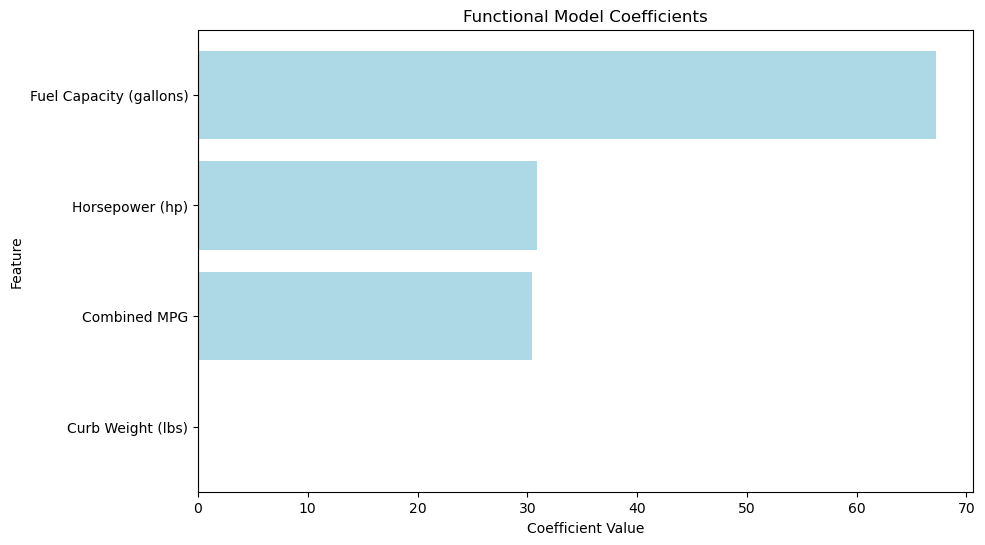

In [57]:
# Filter for functional features
functional_coefs = coefs[coefs['Feature'].isin(functional_features)  & 
    ~coefs['Feature'].str.startswith('Drivetrain_') & (coefs['Feature'] != 'Age')
]

top_functional_coefs = functional_coefs.reindex(functional_coefs['Coefficient'].sort_values(ascending=False).index)


plt.figure(figsize=(10, 6))
plt.barh(top_functional_coefs['Feature'], top_functional_coefs['Coefficient'], color='lightblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Functional Model Coefficients')
plt.axvline(0, color='grey', linewidth=0.8)
plt.gca().invert_yaxis()
plt.show()

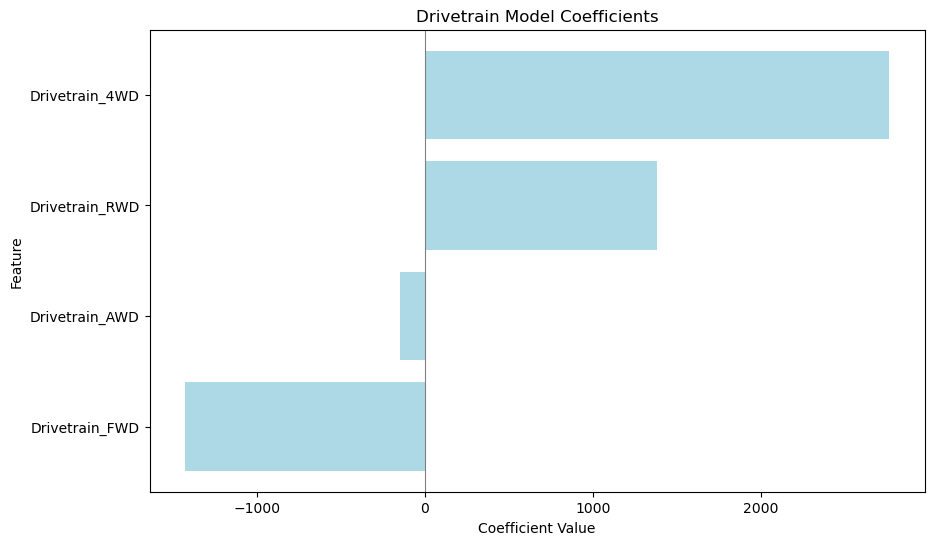

In [65]:
# Filter for features that start with "Drivetrain_"
drivetrain_coefs = coefs[coefs['Feature'].str.startswith('Drivetrain_')]

top_drivetrain_coefs = drivetrain_coefs.reindex(drivetrain_coefs['Coefficient'].sort_values(ascending=False).index)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_drivetrain_coefs['Feature'], top_drivetrain_coefs['Coefficient'], color='lightblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Drivetrain Model Coefficients')
plt.axvline(0, color='grey', linewidth=0.8)
plt.gca().invert_yaxis()
plt.show()


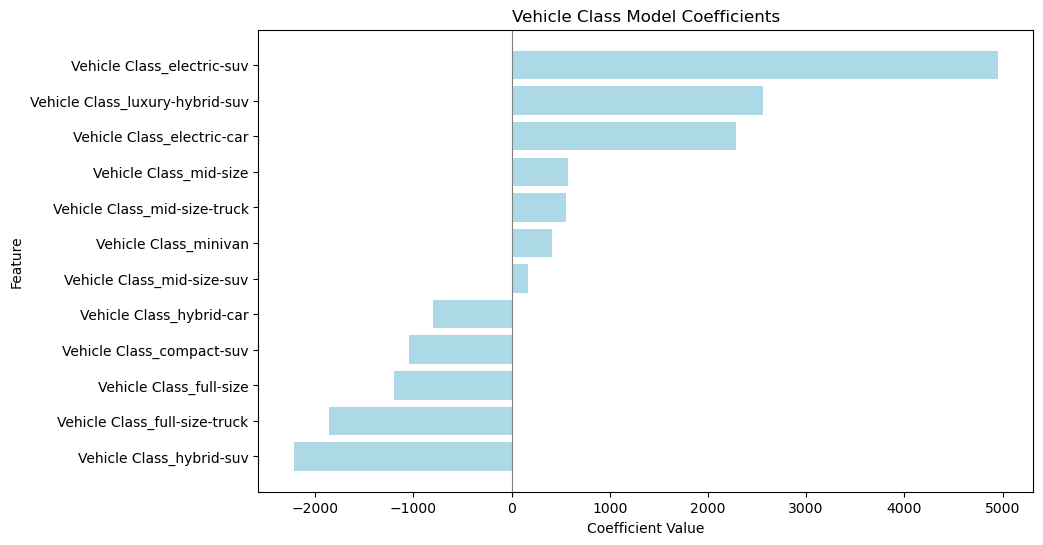

In [59]:
functional_coefs = coefs[coefs['Feature'].isin(vehicle_class_features)]

# Sort by absolute values of coefficients, preserving original signs
top_functional_coefs = functional_coefs.reindex(functional_coefs['Coefficient'].sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))
plt.barh(top_functional_coefs['Feature'], top_functional_coefs['Coefficient'], color='lightblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Vehicle Class Model Coefficients')
plt.axvline(0, color='grey', linewidth=0.8)
plt.gca().invert_yaxis()
plt.show()

In [60]:
topic_features = ['Best Car Ever', 'No Technical Issues', 'Recommended for Family', 'Fun to Drive', 'Great Gas Mileage', 'Trucks', 'Interior/Features']


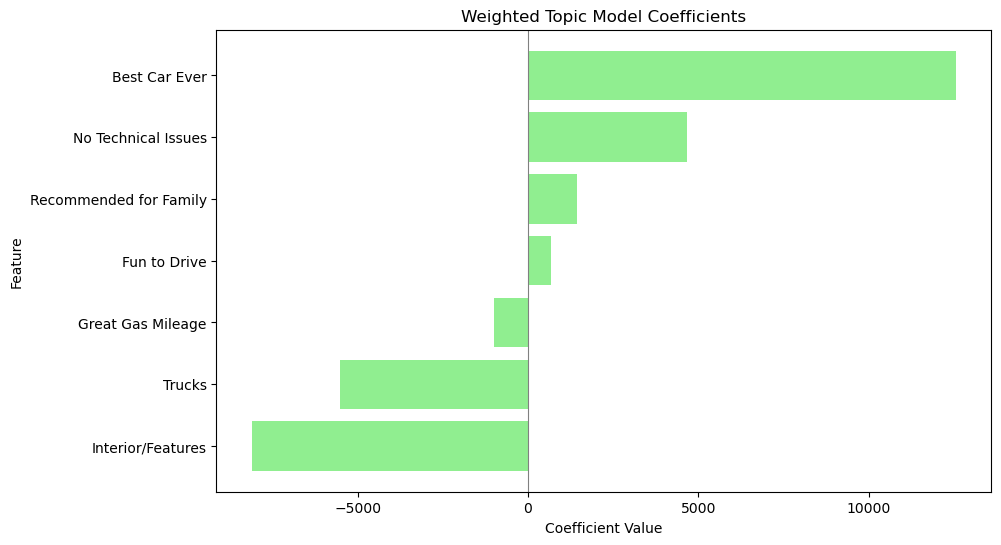

In [61]:
# Filter for experiental features
experiential_coefs = coefs[coefs['Feature'].isin(weighted_topic_features)]

# Sort by absolute values of coefficients, preserving original signs
top_experiential_coefs = experiential_coefs.reindex(experiential_coefs['Coefficient'].sort_values(ascending=False).index)

plt.figure(figsize=(10, 6))
plt.barh(topic_features, top_experiential_coefs['Coefficient'], color='lightgreen')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Weighted Topic Model Coefficients')
plt.axvline(0, color='grey', linewidth=0.8)
plt.gca().invert_yaxis()
plt.show()

In [62]:
top_experiential_coefs

,Feature,Coefficient
9,Topic_4_Weighted,12563.581150
8,Topic_3_Weighted,4679.562847
12,Topic_8_Weighted,1439.066440
13,Topic_9_Weighted,685.701489
11,Topic_7_Weighted,-1004.834450
10,Topic_5_Weighted,-5527.654152
6,Topic_0_Weighted,-8108.565037


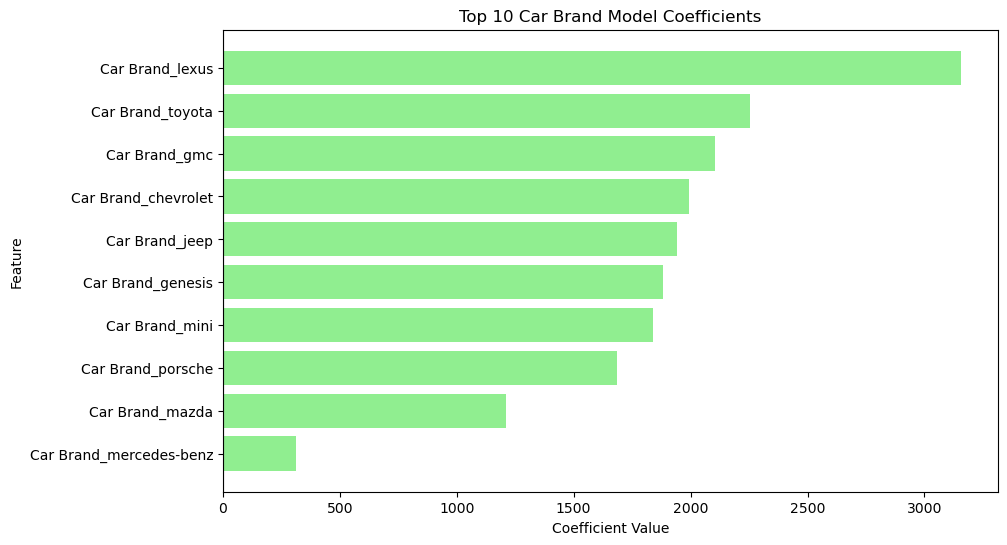

In [63]:
# Filter for experiental features
experiential_coefs = coefs[coefs['Feature'].isin(experiential_features[8:])]

# Sort by absolute values of coefficients, preserving original signs
top_experiential_coefs = experiential_coefs.reindex(experiential_coefs['Coefficient'].sort_values(ascending=False).index).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_experiential_coefs['Feature'], top_experiential_coefs['Coefficient'], color='lightgreen')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Car Brand Model Coefficients')
plt.axvline(0, color='grey', linewidth=0.8)
plt.gca().invert_yaxis()
plt.show()


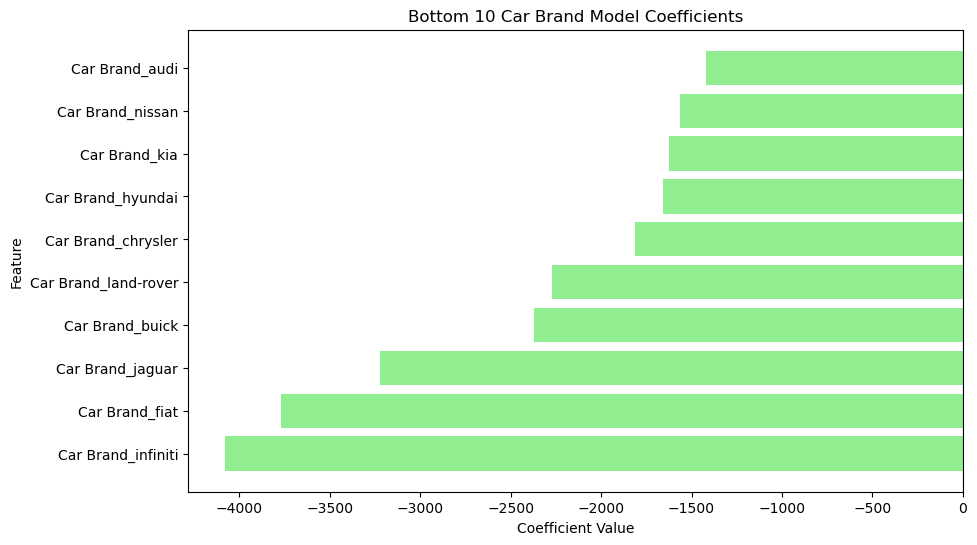

In [64]:
# Filter for experiental features
experiential_coefs = coefs[coefs['Feature'].isin(experiential_features[8:])]

# Sort by absolute values of coefficients, preserving original signs
top_experiential_bottom = experiential_coefs.reindex(experiential_coefs['Coefficient'].sort_values(ascending=False).index).tail(10)

plt.figure(figsize=(10, 6))
plt.barh(top_experiential_bottom['Feature'], top_experiential_bottom['Coefficient'], color='lightgreen')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Bottom 10 Car Brand Model Coefficients')
plt.axvline(0, color='grey', linewidth=0.8)
plt.gca().invert_yaxis()
plt.show()

In [16]:
scaled_df = pd.DataFrame.from_dict(dict(zip(X.columns, X_scaled)))

In [17]:
X[[col for col in scaled_df.columns if col.startswith('Topic')]].describe()

,Topic_0_Weighted,Topic_2_Weighted,Topic_3_Weighted,Topic_4_Weighted,Topic_5_Weighted,Topic_7_Weighted,Topic_8_Weighted,Topic_9_Weighted
count,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,0.007139,0.016743,-0.028632,0.011906,0.002538,0.008451,-0.001164,0.016614
std,0.037304,0.027104,0.053195,0.019842,0.043594,0.028169,0.045177,0.024851
min,-0.250869,-0.190219,-0.232399,-0.069327,-0.448444,-0.212630,-0.394128,-0.169179
25%,-0.007666,0.006058,-0.056317,0.001406,-0.000474,0.001089,-0.011132,0.004821
50%,0.009908,0.015545,-0.017118,0.011496,0.001188,0.012322,0.005867,0.013954
75%,0.025601,0.027408,0.007419,0.022541,0.003873,0.021602,0.018554,0.027459
max,0.111592,0.112172,0.095436,0.090313,0.160792,0.079459,0.129496,0.122573


In [18]:
scaled_df[[col for col in scaled_df.columns if col.startswith('Topic')]].describe()

,Topic_0_Weighted,Topic_2_Weighted,Topic_3_Weighted,Topic_4_Weighted,Topic_5_Weighted,Topic_7_Weighted,Topic_8_Weighted,Topic_9_Weighted
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.174023,-0.036949,0.014781,0.038731,-0.010294,0.075765,0.003446,-0.001678
std,1.688562,0.806604,0.845143,0.833526,0.792270,0.973525,0.906653,0.832681
min,-0.804030,-1.180614,-1.414372,-1.180614,-0.731774,-0.839165,-2.141791,-0.839165
25%,-0.232582,-0.288195,-0.272236,-0.232582,-0.278331,-0.253835,-0.282728,-0.272236
50%,-0.168497,-0.173194,-0.168497,-0.142532,-0.168497,-0.168497,-0.173194,-0.168497
75%,-0.096374,-0.096374,-0.091922,-0.078567,-0.091922,-0.078567,-0.096374,-0.096374
max,12.727922,5.351296,5.351296,5.351296,5.351296,5.351296,5.351296,5.351296


In [19]:
scaled_df[scaled_df['Topic_4_Weighted'] == scaled_df['Topic_4_Weighted'].max()][[col for col in scaled_df.columns if col.startswith('Car Brand')]]

,Car Brand_acura,Car Brand_alfa-romeo,Car Brand_audi,Car Brand_bmw,Car Brand_buick,Car Brand_cadillac,Car Brand_chevrolet,Car Brand_chrysler,Car Brand_dodge,Car Brand_fiat,...,Car Brand_mercedes-benz,Car Brand_mini,Car Brand_mitsubishi,Car Brand_nissan,Car Brand_porsche,Car Brand_subaru,Car Brand_tesla,Car Brand_toyota,Car Brand_volkswagen,Car Brand_volvo
16,5.351296,5.351296,5.351296,5.351296,-0.186871,-0.186871,-0.186871,-0.186871,-0.186871,-0.186871,...,-0.186871,-0.186871,-0.186871,-0.186871,-0.186871,-0.186871,-0.186871,-0.186871,-0.186871,-0.186871


In [20]:
aggregated_data[aggregated_data['Topic_4_Weighted'] == aggregated_data['Topic_4_Weighted'].max()]

,Model Full Name,Year,Horsepower (hp),Curb Weight (lbs),Combined MPG,Fuel Capacity (gallons),Age,Average KBB Fair Price ($),Vehicle Class,Car Brand,Topic_0_Weighted,Topic_2_Weighted,Topic_3_Weighted,Topic_4_Weighted,Topic_5_Weighted,Topic_7_Weighted,Topic_8_Weighted,Topic_9_Weighted,Drivetrain
11,Audi A6,2019,236.0,3761.0,27.0,19.3,5.0,23505.5,mid-size,audi,0.071297,0.003178,-0.029165,0.090313,0.000531,-0.000881,0.041378,0.019941,AWD
